In [1]:
import numpy as np
import shap

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import log_loss

import matplotlib.pyplot as plt


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# Random Forest

Random Forests is an ensemble machine learning method that uses a collection of decision trees to perform classification and regression tasks. Random forests uses “bagging” to train independent decision trees in parallel from random bootstrap samples of the data set and features, with final model prediction an average (for regression) or vote (for classification) over all the predictions of all individual trees. Randomness ensures individual trees have low correlations with each other, which reduces the risk of bias. The presence of a large number of trees also reduces the problem of overfitting, which occurs when a model incorporates too much “noise” in the training data and makes poor decisions as a result.

### Prepare Dataset

In [2]:
# Load the digits dataset
digits = load_digits()
X = digits.data
y = digits.target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Train Random Forest Model

In [3]:
# Train a Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=20, random_state=42)
rf_model.fit(X_train, y_train)


RandomForestClassifier(n_estimators=20, random_state=42)

### Evaluate Model Performance 

In [4]:
# Make predictions on the test set
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on the test set: {accuracy:.2f}")


# Conusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Precision, Recall, F1 Score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("\nPrecision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

Accuracy on the test set: 0.96

Confusion Matrix:
[[32  0  0  0  1  0  0  0  0  0]
 [ 0 28  0  0  0  0  0  0  0  0]
 [ 0  0 33  0  0  0  0  0  0  0]
 [ 0  0  0 33  0  1  0  0  0  0]
 [ 0  0  0  0 45  0  0  1  0  0]
 [ 0  0  0  0  0 43  1  0  0  3]
 [ 1  0  0  0  0  0 34  0  0  0]
 [ 0  0  0  0  0  0  0 33  0  1]
 [ 0  1  0  0  0  0  0  0 29  0]
 [ 0  1  0  0  1  1  0  0  0 37]]

Precision: 0.9644015516987322
Recall: 0.9638888888888889
F1-Score: 0.9639240750368868


In [5]:
# predict_proba returns an array of shape (n_samples, n_classes)
y_proba = rf_model.predict_proba(X_test)

# Calculate log loss
logloss = log_loss(y_test, y_proba)
print(f"Log Loss: {logloss:.4f}")

Log Loss: 0.2816


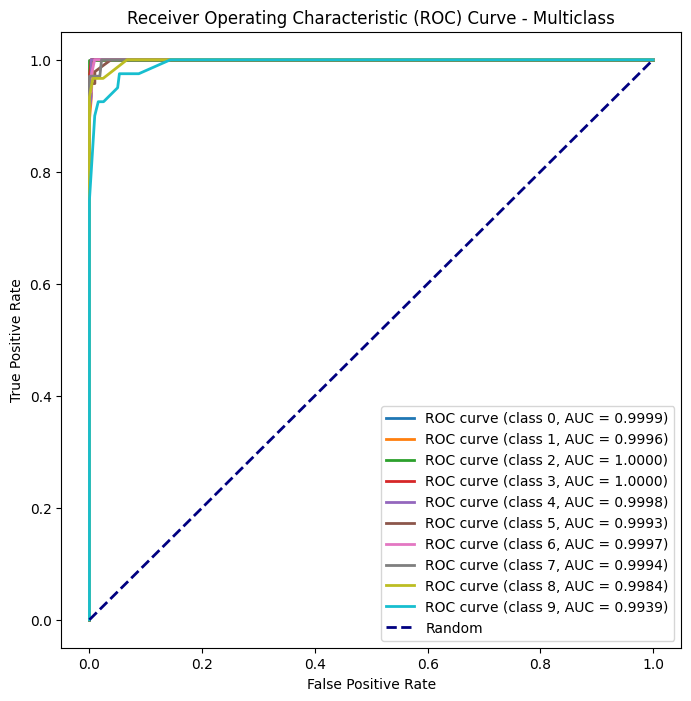

In [6]:
# Binarize the labels
y_test_bin = label_binarize(y_test, classes=list(range(10)))  # Assuming 10 classes in the digits dataset

# Calculate ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(10):  # Assuming 10 classes
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(8, 8))
for i in range(10):  # Assuming 10 classes
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve (class {i}, AUC = {roc_auc[i]:.4f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Multiclass')
plt.legend(loc='lower right')
plt.show()

### Model Interpretability: Feature Importance

#### Gini Importance

Gini importance measure of feature importance in a decision tree-based models. It is calculated based on the Gini impurity criterion, which measures the degree of impurity or disorder in a set of data points Gini importance quantifies how often a feature is used to split the data across all trees and how much it contributes to the reduction in impurity. This aids in model interpretability by providing insights into which features are more influential in making predictions.

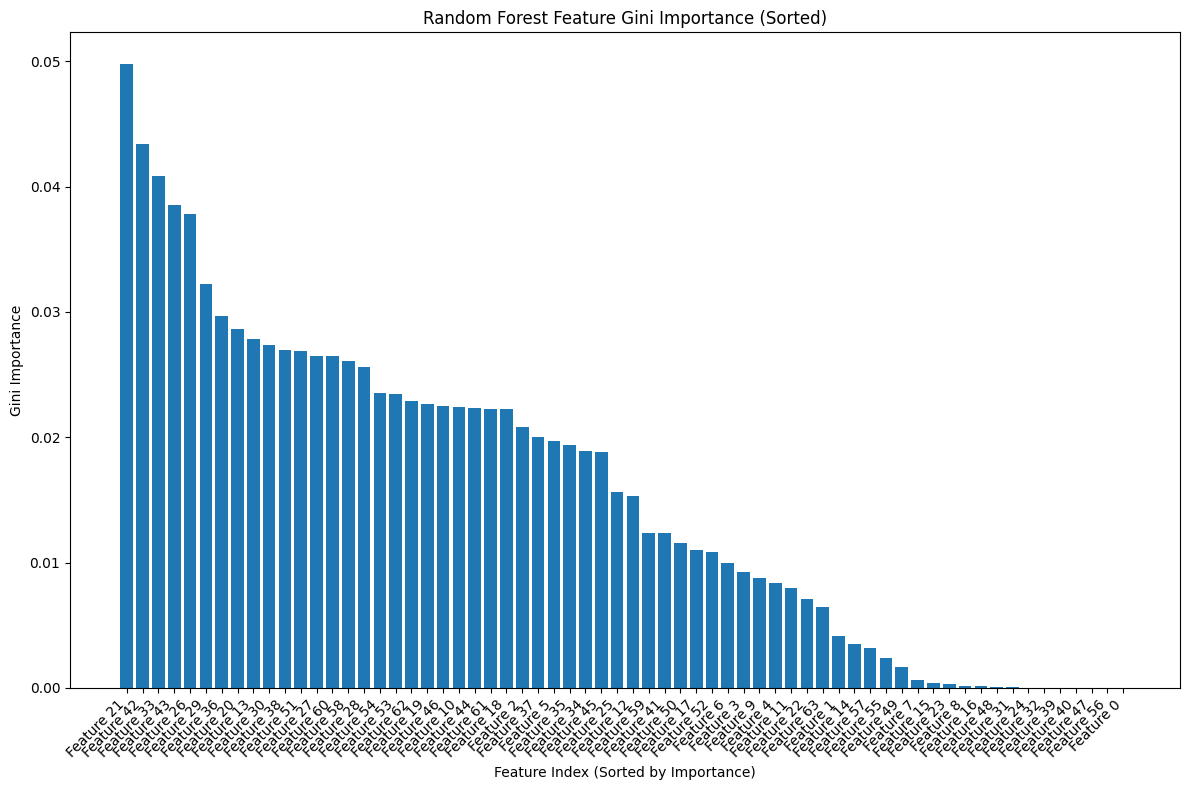

In [7]:
# Get feature importances
feature_importances = rf_model.feature_importances_

# Get sorted indices and importances
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_importances = feature_importances[sorted_indices]

# Get feature names
feature_names = [f"Feature {i}" for i in sorted_indices]

# Create a bar chart for sorted Gini importance with feature labels
plt.figure(figsize=(12, 8))
plt.bar(range(len(sorted_importances)), sorted_importances, align="center")
plt.xlabel("Feature Index (Sorted by Importance)")
plt.ylabel("Gini Importance")
plt.title("Random Forest Feature Gini Importance (Sorted)")
plt.xticks(range(len(sorted_importances)), feature_names, rotation=45, ha="right")
plt.tight_layout()
plt.show()

#### SHAP (SHapley Additive exPlanations)

SHAP is a model-agnostic framework used to interpret ML model output, e.g., feature importance. SHAP values allocate the contribution of each feature to the model's prediction, taking into account the interactions and dependencies between features.

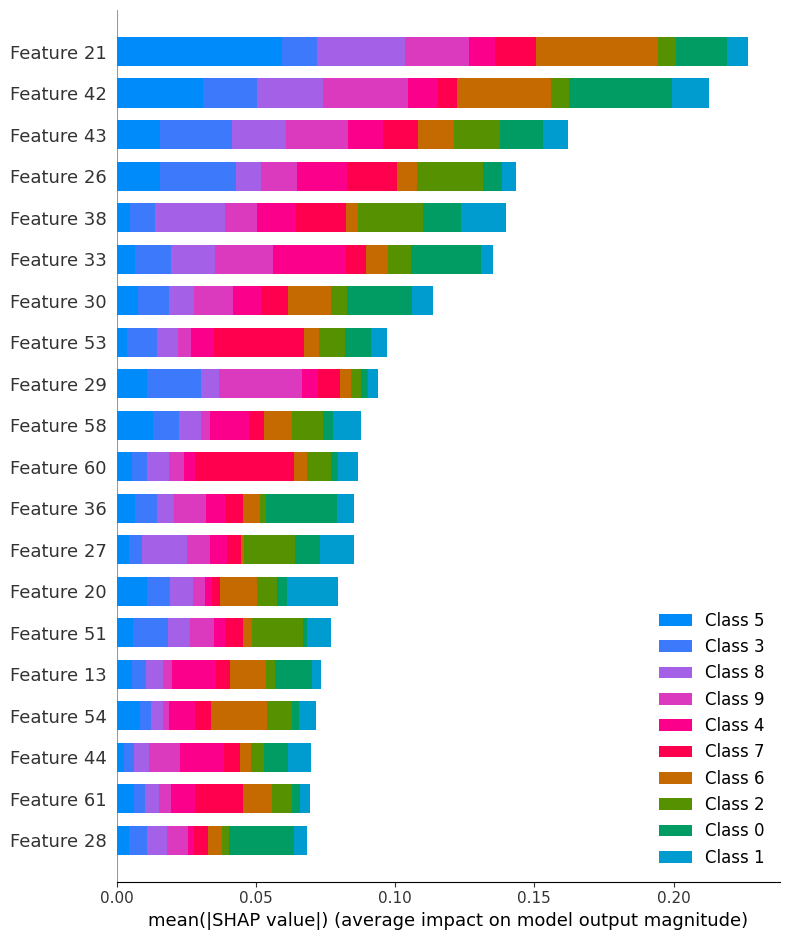

In [8]:
# Explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

# Summary plot without explicit feature names
shap.summary_plot(shap_values, X_test)

plt.show()